# Descenso por gradiente en dos dimensiones



In [9]:
import matplotlib.pyplot as plt
import numpy as np
import nni
from matplotlib.animation import FuncAnimation

In [2]:
f = nni.beale_function
df_dx = nni.beale_gradient_x
df_dy = nni.beale_gradient_y

# Search space
min_x = -4.5
max_x = 4.5
min_y = -4.5
max_y = 4.5

x = np.linspace(min_x, max_x, 100)
y = np.linspace(min_y, max_y, 100)

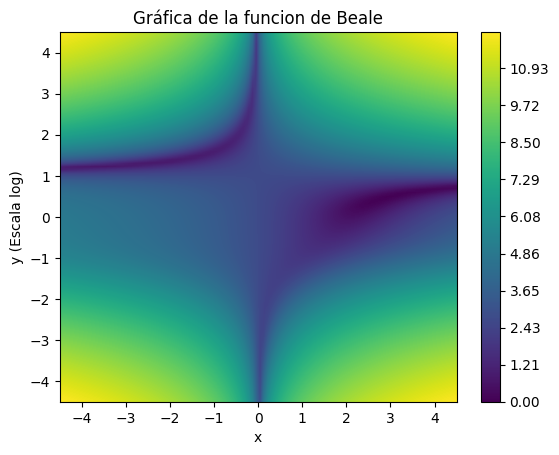

In [3]:
# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the corresponding z values using the function f
Z = f(X, Y)
# Applying a logarithmic transformation to Z values
Z_log = np.log(Z + 1)  # Adding 1 to avoid taking log of zero

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.colorbar()

# Add labels and title to the plot
plt.xlabel('x')
plt.ylabel('y (Escala log)')
plt.title('Gráfica de la funcion de Beale')

# Show the plot
plt.show()

In [6]:
class Optimizer:
    def __init__(self, tolerance=1e-6):
        self.tolerance = tolerance
        self.history = []


class GradientDescentOptimizer(Optimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        super().__init__(tolerance=tolerance)
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations

    def next_params(self, gradient, params):
        return [param - self.learning_rate * grad for param, grad in zip(params, gradient)]
    
    def optimize(self, function, gradient, initial_params):
        self.history = []
        params = initial_params
        iteration = 0

        while iteration < self.max_iterations:
            log = {'iter': iteration, 'params': params, 'value': function(*params)}
            self.history.append(log)

            gradient_values = gradient(*params)
            updated_params = self.next_params(gradient_values, params)
            if self._converged(params, updated_params):
                break
            params = updated_params
            iteration += 1
        return params
    
    def _converged(self, params, updated_params):
        return all(abs(param - updated_param) < self.tolerance for param, updated_param in zip(params, updated_params))
    
    def get_history(self):
        return self.history
    

In [22]:
optimizer = GradientDescentOptimizer(learning_rate=0.005, max_iterations=50, tolerance=1e-6)

# Initial guess
initial_params = [1.5, 1.5]

# Optimize the function
optimized_params = optimizer.optimize(f, lambda x, y: [df_dx(x, y), df_dy(x, y)], initial_params)

print(f'Optimized parameters: {optimized_params}')
print(f'Optimized function value: {f(*optimized_params)}')

Optimized parameters: [2.0210978219759603, 0.14994536909187114]
Optimized function value: 0.4957814451705918


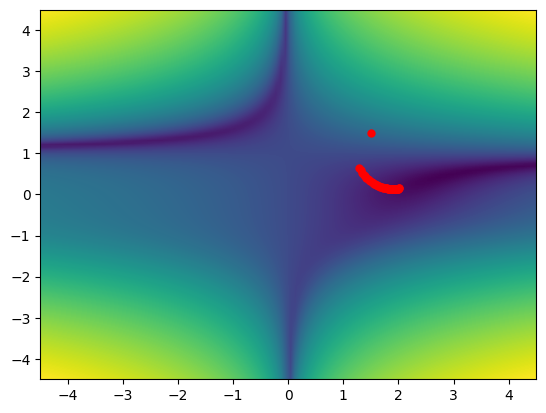

In [23]:
# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]


# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(x_values, y_values, 'r.', markersize=10)
plt.show()

## Momentum optimizer

In [16]:
class MomentumOptimizer(GradientDescentOptimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6, beta=0.9):
        super().__init__(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=tolerance)
        self.beta = beta

    def next_params(self, gradient, params):
        if not hasattr(self, 'momentum'):
            self.momentum = [0] * len(params)
        self.momentum = [self.beta * m + (1 - self.beta) * grad for m, grad in zip(self.momentum, gradient)]
        return [param - self.learning_rate * mom for param, mom in zip(params, self.momentum)]
        

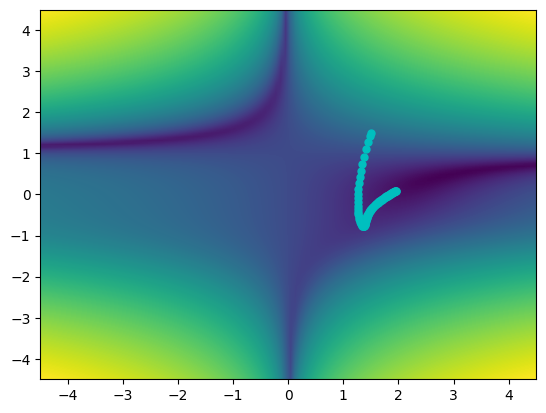

In [25]:
optimizer = MomentumOptimizer(learning_rate=0.005, max_iterations=100, tolerance=1e-6)

# Optimize the function
optimized_params = optimizer.optimize(f, lambda x, y: [df_dx(x, y), df_dy(x, y)], initial_params)

# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(x_values, y_values, 'c.', markersize=10)
plt.show()